<h1><center>SSP -- Final Project</center></h1>

<h1><center>Qing Zhou -- s 3088782, bachelor</center></h1>

In [1]:
%config InlineBackend.figure_format = 'retina' 
from math import *
import time
import scipy.io
import numpy as np
import scipy as sp
from scipy.optimize import newton
from astropy.io import fits
from scipy import stats
import seaborn as sns
from scipy.optimize import newton,curve_fit
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import figure, show

The observed data can be written in the form:
$$\bf{x} = s+w$$
where $\bf{x}$ are the observed data and $\bf{w}$ are the White Gaussian Noise $\sim \cal{N}(0,0.0025)$. The signal is assumed to follow the model of the form below:
$$s = A \times \left(\frac{\nu}{\nu_0}\right)^{\alpha}\left(1+\frac{\nu}{\nu_0}\right)^{-4\alpha}$$
where $\nu$ is the frequency and $A$, $\nu_0$, $\alpha$ are parameters to be determined.

## Problem 1

In [2]:
#reading the data
contents = scipy.io.loadmat('Project_data.mat',squeeze_me=True)
freq = np.asarray(contents['nu']) #reading freq.column in an array
Signal = np.asarray(contents['signal']) #reading Signal column
SpN = np.asarray(contents['signal_plus_noise']) # Signal + Noise

To estimate the parameters qualitatively, the easiest way is to look at the maximum of the model. To find at which frequency this maximum occurs, we take the derivative of the model w.r.t. the frequency $\nu$, so that:
$$f'(\nu) = \frac{A\alpha}{\nu_0}\left(\frac{\nu}{\nu_0}\right)^{\alpha-1}\left(\frac{\nu}{\nu_0}+1\right)^{-4\alpha-1}\left(1-3\frac{\nu}{\nu_0}\right)$$
Setting it to zero yields the maximum $\nu$ of the model function:
$$f'(\nu) = 0\implies \nu=\frac{\nu_0}{3}$$
By looking at the plot of the model function, it can be seen that the maximum occurs at $\nu\approx \frac{1}{3}$, so we can estimate that $\nu_0\sim 1$. With this information we can simplify the model function to:
$$f(\nu) = A\nu^{\alpha}(1+\nu)^{-4\alpha}$$. To infer the value of the remaining two parameters, now pay special attention to the beginning and end of the model function. It can be inferred that the function begins at approximately $\nu=0.05$, with a value of $\sim 0.5$, and ends at $\nu=1$, with a value of $\sim 0.674$. Substitute the two data points into the simplified model function we can obtain the following system of equations of $\nu_0, \alpha$:
\begin{cases}
A(0.05)^{\alpha}(1+0.05)^{-4\alpha} =0.5\\
A2^{-4\alpha} =0.674
\end{cases}
Now divide the first equation by the second equation we obtain an equation of $\alpha$ only:
$$2^{4\alpha}(0.05)^{\alpha}(1+0.05)^{-4\alpha}=\frac{0.5}{0.674}$$
Solving this equation with $\textit{scipy.optimize.newton}$, we find $\alpha\sim 0.714$, and plug this into any one of the equations above, we obtain $A\sim 4.82$.
Now, to verify if the above steps indeed work, we can estimate the parameters using $\textit{cruve_fit}$:

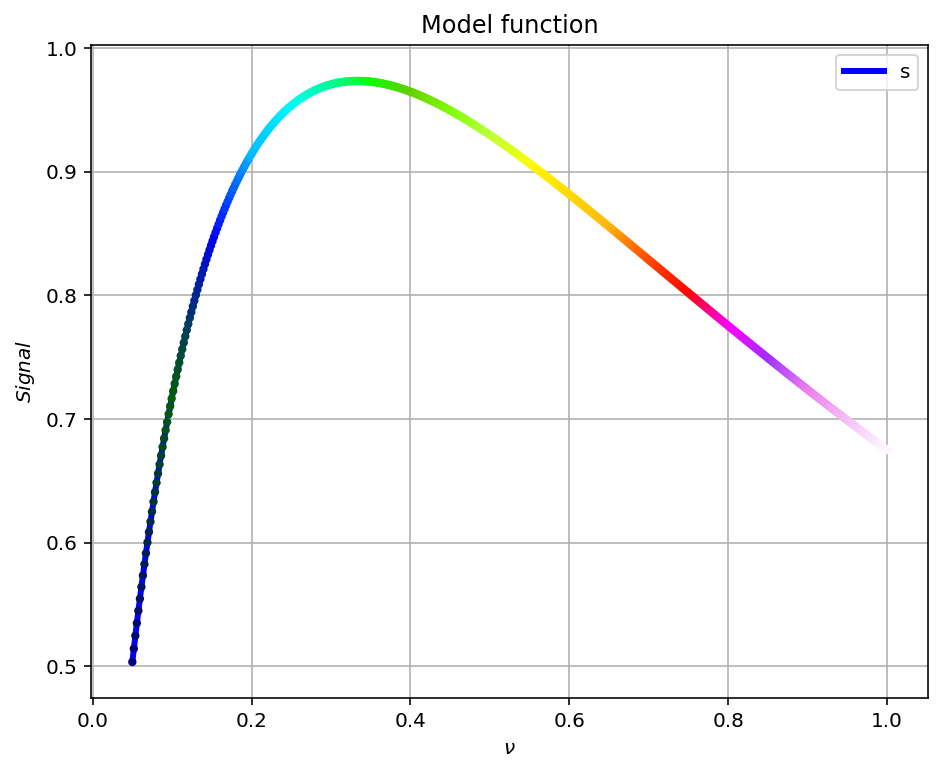

In [3]:
#plot the model function 
m = np.arange(len(freq))
plt.figure(figsize=(7.5,6))
plt.scatter(freq,Signal,c=m,marker='o',s=10,cmap='gist_ncar',zorder=2,alpha=1)
plt.plot(freq,Signal,color='blue',alpha=1,lw=3,zorder=1,label='s')
plt.title("Model function")
plt.xlabel(r'$\nu$')
plt.ylabel(r'$Signal$')
plt.legend()
plt.grid()
plt.show()

In [4]:
func = lambda x: 16.**x * .05**x * 1.05**(-4*x)-.5/.674

rt = newton(func,1.)
rt2 = .674*16**(np.round(rt,2))
print "The value of alpha is found to be: ",np.round(rt,2)
print "The value of nu0 is found to be: ",np.round(rt2,2)



The value of alpha is found to be:  0.71
The value of nu0 is found to be:  4.83


In [5]:
#define the model function

def model(nu,A,nu0,alpha):
    x = nu/nu0
    return A * x**alpha * (1.+x)**(-4*alpha)

#fit the model to infer the best estimate

popt,pcov = curve_fit(model, freq, Signal)
print "The best estimates of the parameters are found to be: A = ",popt[0],", nu0 = ",popt[1],", alpha = ",popt[2]

The best estimates of the parameters are found to be: A =  4.7 , nu0 =  1.0 , alpha =  0.7


In the limit $\nu \ll \nu_0$, we have $\frac{\nu}{\nu_0}\to 0$, so that the third term $\left(\right)^{-4\alpha}\to 1$, and the model is dominated by the first term and the second term $\left(\frac{\nu}{\nu_0}\right)^{\alpha}$, so that we have in the limit $\nu \ll \nu_0$:
$$f(\nu)\approx A\left(\frac{\nu}{\nu_0}\right)^{\alpha};$$

In the limit $\nu \gg \nu_0$, we have $\frac{\nu}{\nu_0}\to \infty$ and $\frac{\nu}{\nu_0}+1\to \frac{\nu}{\nu_0}$, and the model function can be simplified to:
$$f(\nu) \approx A\left(\frac{\nu}{\nu_0}\right)^{-3\alpha}$$

## Problem 2

## Maximum Likelihood Estimator

The observed data point can be fit with the following model:
$$x_i = A\times \left(\frac{\nu_i}{\nu_0}\right)^{\alpha}\left(1+\frac{\nu_i}{\nu_0}\right)^{-4\alpha}+w_i$$
the PDF is:
$$p(x;A,\nu_0,\alpha) = \frac{1}{(2\pi \sigma^2)^{N/2}}\exp\left[-\frac{1}{2\sigma^2}\sum_{i=1}^N\left(x_i-A\left(\frac{\nu_i}{\nu_0}\right)^{\alpha}\left(1+\frac{\nu_i}{\nu_0}\right)^{-4\alpha}\right)^2\right]$$
taking the derivative of the log likelihood function yields:
\begin{align*}
f_1=\frac{\partial \ln p(x;A,\nu_0,\alpha)}{\partial A} &= \frac{1}{\sigma^2}\sum_{i=1}^N\left(x_i-A\left(\frac{\nu_i}{\nu_0}\right)^{\alpha}\left(1+\frac{\nu_i}{\nu_0}\right)^{-4\alpha}\right)\left(\frac{\nu_i}{\nu_0}\right)^{\alpha}\left(1+\frac{\nu_i}{\nu_0}\right)^{-4\alpha}\\
f_2=\frac{\partial \ln p(x;A,\nu_0,\alpha)}{\partial \nu_0} &= \frac{A\alpha}{\sigma^2}\sum_{i=1}^N\left(x_i-A\left(\frac{\nu_i}{\nu_0}\right)^{\alpha}\left(1+\frac{\nu_i}{\nu_0}\right)^{-4\alpha}\right)\left(\frac{\nu_i}{\nu_0}\right)^{\alpha}\left(1+\frac{\nu_i}{\nu_0}\right)^{-4\alpha}\left(\frac{3\nu_i}{\nu_0}-1\right)\left(\frac{1}{\nu_0+\nu_i}\right)\\
f_3=\frac{\partial \ln p(x;A,\nu_0,\alpha)}{\partial \alpha} &= \frac{A}{\sigma^2}\sum_{i=1}^N\left(x_i-A\left(\frac{\nu_i}{\nu_0}\right)^{\alpha}\left(1+\frac{\nu_i}{\nu_0}\right)^{-4\alpha}\right)\left(\frac{\nu_i}{\nu_0}\right)^{\alpha}\left(1+\frac{\nu_i}{\nu_0}\right)^{-4\alpha}\left[\ln\left(\frac{\nu_i}{\nu_0}\right)-4\ln\left(1+\frac{\nu_i}{\nu_0}\right)\right]\\
\end{align*}
Let:
\begin{align*}
g&=g(\nu_0,\alpha) \equiv \left(\frac{\nu_i}{\nu_0}\right)^{\alpha}\left(1+\frac{\nu_i}{\nu_0}\right)^{-4\alpha}\\
h&=h(\nu_0) \equiv \left(\frac{3\nu_i}{\nu_0}-1\right)\left(\frac{1}{\nu_0+\nu_i}\right)\\
k&=k(\nu_0) \equiv \ln\left(\frac{\nu_i}{\nu_0}\right)-4\ln\left(1+\frac{\nu_i}{\nu_0}\right)
\end{align*}
with their derivatives:
\begin{align*}
g_1 &= \frac{\partial g}{\partial \nu_0} =-\frac{\alpha(\nu_0-3\nu_i)}{\nu_0(\nu_i+\nu_0)}g\\
g_2 &= \frac{\partial g}{\partial \alpha}=kg\\
h_1 &= \frac{\partial h}{\partial \nu_0}=\frac{\nu_0^2-6\nu_0\nu_i-3\nu_i^2}{\nu_0^2(\nu_0+\nu_i)^2}\\
k_1 &= \frac{\partial k}{\partial \nu_0}=\frac{3\nu_i-\nu_0}{\nu_0(\nu_0+\nu_i)}
\end{align*}
and the expressions for $f_1$, $f_2$ and $f_3$ can be simplified to:
\begin{align*}
f_1(A,\nu_0,\alpha) &= \frac{1}{\sigma^2}\sum_{i=1}^N\left(x_i-Ag(\nu_0,\alpha)\right)g(\nu_0,\alpha)=\frac{1}{\sigma^2}\sum_{i=1}^N (x_i-Ag)g\\
f_2(A,\nu_0,\alpha) &=\frac{1}{\sigma^2}\sum_{i=1}^N A\alpha\left(x_i-Ag(\nu_0,\alpha)\right)g(\nu_0,\alpha)h(\nu_0)=\frac{1}{\sigma^2}\sum_{i=1}^N A\alpha(x_i-Ag)gh\\
f_3(A,\nu_0,\alpha) &=\frac{1}{\sigma^2}\sum_{i=1}^N A\left(x_i-Ag(\nu_0,\alpha)\right)g(\nu_0,\alpha)k(\nu_0)=\frac{1}{\sigma^2}\sum_{i=1}^N A (x_i-Ag)gk
\end{align*}
and the second derivatives are found to be:
\begin{align*}
J_{11}&=\frac{\partial f_1}{\partial A} =-\frac{1}{\sigma^2}\sum_{i=1}^Ng^2\\
J_{12} &=\frac{\partial f_1}{\partial \nu_0} = \frac{1}{\sigma^2}\sum_{i=1}^N g_1(x_i-2Ag)\\
J_{13} &=\frac{\partial f_1}{\partial \alpha} = \frac{1}{\sigma^2}\sum_{i=1}^Ng_2(x_i-2Ag)\\
J_{21}&=\frac{\partial f_2}{\partial A} =\frac{1}{\sigma^2}\sum_{i=1}^N\alpha gh(x_i-2Ag)\\
J_{22} &=\frac{\partial f_2}{\partial \nu_0} = \frac{1}{\sigma^2}\sum_{i=1}^N A\alpha \left[hg_1(x_i-2Ag)+gh_1(x_i-Ag)\right]\\
J_{23} &=\frac{\partial f_2}{\partial \alpha} = \frac{1}{\sigma^2}\sum_{i=1}^N Ah\left[g(x_i-Ag)+\alpha g_2(x_i-2Ag)\right]\\
J_{31}&=\frac{\partial f_3}{\partial A} = \frac{1}{\sigma^2}\sum_{i=1}^Ngk(x_i-2Ag)\\
J_{32} &=\frac{\partial f_3}{\partial \nu_0} = \frac{1}{\sigma^2}\sum_{i=1}^N A \left[kg_1(x_i-2Ag)+gk_1(x_i-Ag)\right]\\
J_{33} &=\frac{\partial f_3}{\partial \alpha} = \frac{1}{\sigma^2}\sum_{i=1}^N Akg_2(x_i-2Ag)\\
\end{align*}
Let:
$$\Theta =\begin{bmatrix}
A & \nu_0 & \alpha 
\end{bmatrix}^T$$
and let:

then using the Newton Raphson method, the MLE estimator of $\Theta$ can be found as:
$$\Theta_{i+1} = \Theta_i-J^{-1}\begin{bmatrix}
f_1(A_i,\nu_{0i},\alpha_i)\\
f_2(A_i,\nu_{0i},\alpha_i)\\
f_3(A_i,\nu_{0i},\alpha_i)
\end{bmatrix}$$

In [6]:
#define functions g,h,k and their derivatives, which are the functions that simplify f1,f2,f3
def g(nu,nu0,alpha):
    x = nu/nu0
    return x**(alpha) * (1.+x)**(-4*alpha)
def h(nu,nu0):
    return (3.*nu/nu0-1.) / (nu0+nu)
def k(nu,nu0):
    x = nu/nu0
    return np.log(x) -4*np.log(1.+x)
def g1(nu,nu0,alpha):
    return -alpha*((nu0-3*nu)/(nu0*(nu0+nu)))*g(nu,nu0,alpha)
def g2(nu,nu0,alpha):
    return k(nu,nu0)*g(nu,nu0,alpha)
def h1(nu,nu0):
    return (nu0**2-6*nu0*nu-3*nu**2)/(nu0**2*(nu0+nu)**2)
def k1(nu,nu0):
    return (3*nu-nu0)/(nu0*(nu0+nu))

#define the functions for the 1st order derivatives
def f1(data,nu,A,nu0,alpha):
    return 1./(sig**2)*np.sum((data-A*g(nu,nu0,alpha))*g(nu,nu0,alpha))
    
def f2(data,nu,A,nu0,alpha):
    return 1./(sig**2)*np.sum(A*alpha*(data-A*g(nu,nu0,alpha))*g(nu,nu0,alpha)*h(nu,nu0))
    
def f3(data,nu,A,nu0,alpha):
    return 1./(sig**2)*np.sum(A*(data-A*g(nu,nu0,alpha))*g(nu,nu0,alpha)*k(nu,nu0))
    

#define the functions for the 2nd order derivatives
def J11(data,nu,A,nu0,alpha): #derivative of f1 w.r.t. A
    return -1./(sig**2)*np.sum(g(nu,nu0,alpha)*g(nu,nu0,alpha))
    
def J12(data,nu,A,nu0,alpha): #derivative of f1 w.r.t. nu0
    return 1./(sig**2)*np.sum(g1(nu,nu0,alpha)*(data-2*A*g(nu,nu0,alpha)))
    
def J13(data,nu,A,nu0,alpha): #derivative of f1 w.r.t. alpha
    return 1./(sig**2)*np.sum(g2(nu,nu0,alpha)*(data-2*A*g(nu,nu0,alpha)))
    

def J21(data,nu,A,nu0,alpha): #derivative of f2 w.r.t. A
    return 1./(sig**2)*np.sum(alpha*g(nu,nu0,alpha)*h(nu,nu0)*(data-2*A*g(nu,nu0,alpha)))
    
def J22(data,nu,A,nu0,alpha): #derivative of f1 w.r.t. nu0
    return 1./(sig**2)*np.sum(A*alpha*(h(nu,nu0)*g1(nu,nu0,alpha)*(data-2*A*g(nu,nu0,alpha))
                                       +g(nu,nu0,alpha)*h1(nu,nu0)*(data-A*g(nu,nu0,alpha))))
    

def J23(data,nu,A,nu0,alpha): #derivative of f1 w.r.t. alpha
    return 1./(sig**2)*np.sum(A*h(nu,nu0)*(g(nu,nu0,alpha)*(data-A*g(nu,nu0,alpha))
                                           +alpha*g2(nu,nu0,alpha)*(data-2*A*g(nu,nu0,alpha))))
    

def J31(data,nu,A,nu0,alpha): #derivative of f1 w.r.t. A
    return 1./(sig**2)*np.sum(g(nu,nu0,alpha)*k(nu,nu0)*(data-2*A*g(nu,nu0,alpha)))
    
def J32(data,nu,A,nu0,alpha): #derivative of f1 w.r.t. nu0
    return 1./(sig**2)*np.sum(A*(k(nu,nu0)*g1(nu,nu0,alpha)*(data-2*A*g(nu,nu0,alpha))
                                 +g(nu,nu0,alpha)*k1(nu,nu0)*(data-A*g(nu,nu0,alpha))))
    

def J33(data,nu,A,nu0,alpha): #derivative of f1 w.r.t. alpha
    return 1./(sig**2)*np.sum(A*k(nu,nu0)*g2(nu,nu0,alpha)*(data-2*A*g(nu,nu0,alpha)))
    
    

In [7]:
def J_inv(data,nu,A,nu0,alpha): #The Jacobian
    j11 = J11(data,nu,A,nu0,alpha);j12 = J12(data,nu,A,nu0,alpha);j13 = J13(data,nu,A,nu0,alpha)
    j21 = J21(data,nu,A,nu0,alpha);j22 = J22(data,nu,A,nu0,alpha);j23 = J23(data,nu,A,nu0,alpha)
    j31 = J31(data,nu,A,nu0,alpha);j32 = J32(data,nu,A,nu0,alpha);j33 = J33(data,nu,A,nu0,alpha)
    J = np.matrix(np.array([j11,j12,j13,j21,j22,j23,j31,j32,j33]).reshape(3,3))
  
    return np.linalg.inv(J)
  

In [124]:
sig = .05
Theta0 = [6.,2.,1.]
i = 0
while i < 50: #Theta converges after 50 times of iteration
    Theta_ini = Theta0
    Theta_i = np.matrix(Theta_ini).T
    Theta_f = Theta_i - .3*J_inv(SpN,freq,Theta_ini[0],Theta_ini[1],Theta_ini[2])*np.matrix([f1(SpN,freq,
                Theta_ini[0],Theta_ini[1],Theta_ini[2]),
                f2(SpN,freq,Theta_ini[0],Theta_ini[1],Theta_ini[2]),
                f3(SpN,freq,Theta_ini[0],Theta_ini[1],Theta_ini[2])]).T

    Theta0 = np.array(Theta_f.T).flatten()
    i+=1

Theta_f = Theta_f.reshape(3,1)
A_est = float(Theta_f[0])
nu0_est = float(Theta_f[1])
alpha_est = float(Theta_f[2])
print "The best estimate are found to be (A,nu0,alpha) = ","(",A_est,",",nu0_est,",",alpha_est,")" 



The best estimate are found to be (A,nu0,alpha) =  ( 4.41543193654 , 1.001198466 , 0.674348337691 )


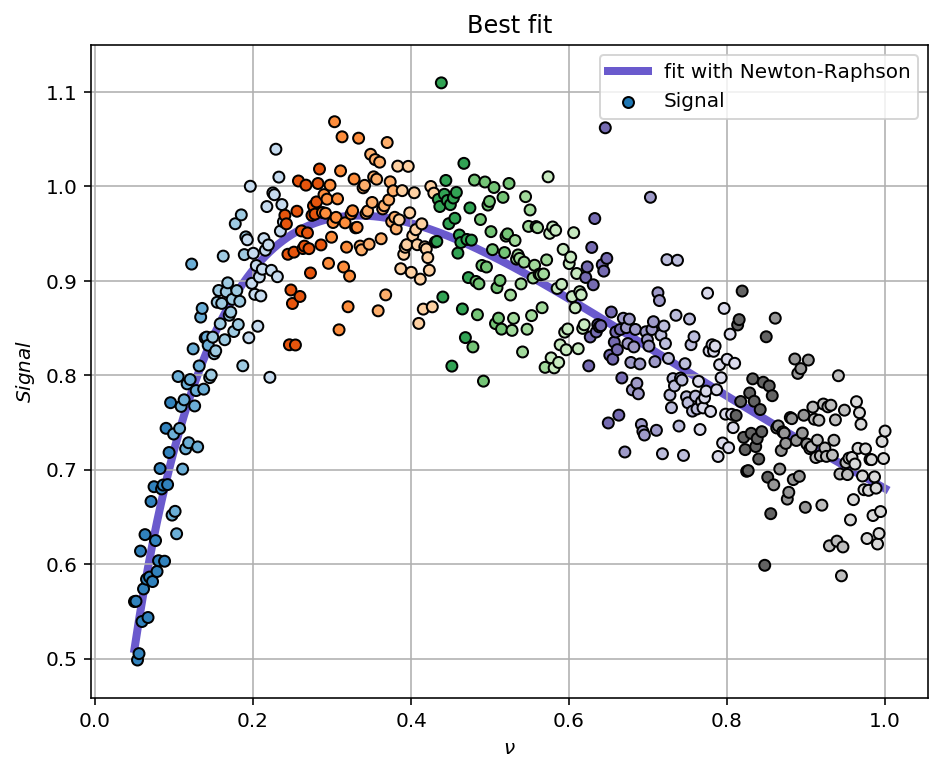

In [9]:
#plot the model function 
m = np.arange(len(freq))
plt.figure(figsize=(7.5,6))
plt.scatter(freq,SpN,c=m,marker='o',edgecolor='k',s=30,cmap='tab20c',zorder=2,alpha=1,label='Signal')
plt.plot(freq,model(freq,A_est,nu0_est,alpha_est),color='slateblue',alpha=1,lw=4,zorder=1,label='fit with Newton-Raphson')
plt.title("Best fit")
plt.xlabel(r'$\nu$')
plt.ylabel(r'$Signal$')
plt.legend()
plt.grid()
plt.show()

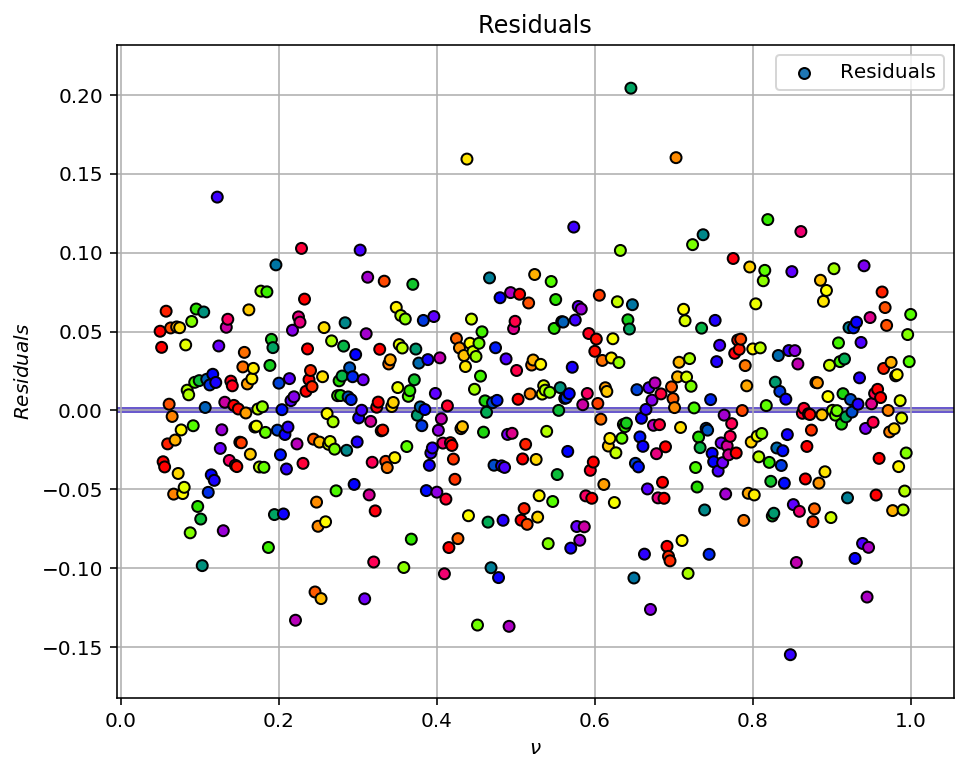

In [10]:
plt.figure(figsize=(7.5,6))
plt.scatter(freq,SpN-model(freq,A_est,nu0_est,alpha_est),c=m,marker='o',edgecolor='k',s=30,cmap='prism',zorder=2,alpha=1,label='Residuals')
plt.axhline(y=0,color='slateblue',lw=3,zorder=1)
plt.title("Residuals")
plt.xlabel(r'$\nu$')
plt.ylabel(r'$Residuals$')
plt.legend()
plt.grid()
plt.show()

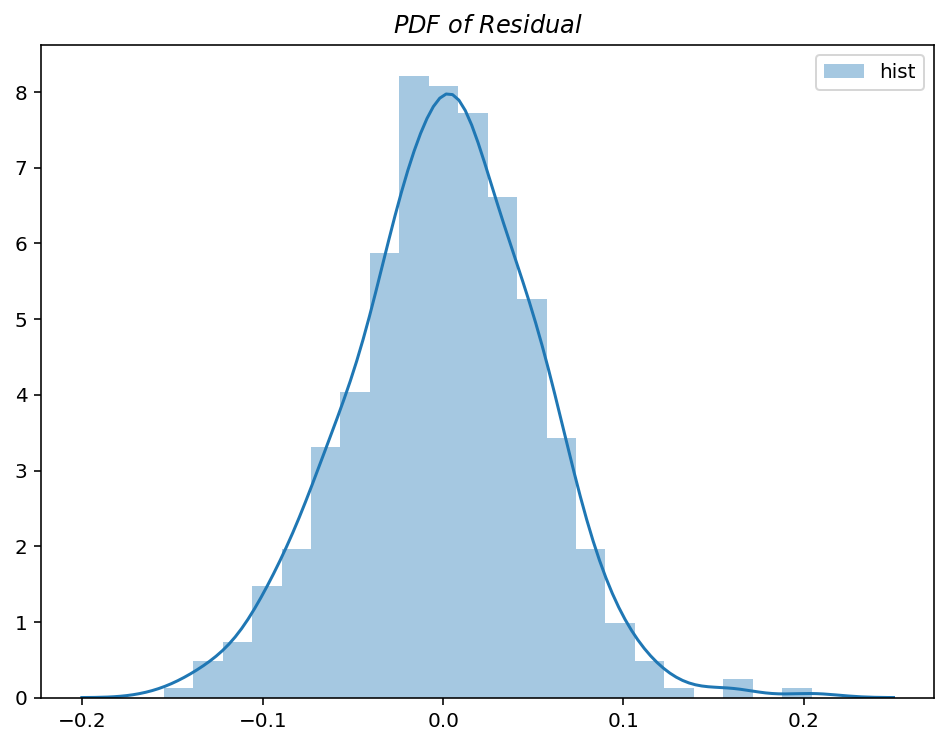

In [11]:
res_dist = SpN-model(freq,A_est,nu0_est,alpha_est)
plt.figure(figsize=(8,6))
sns.distplot(res_dist,kde=True,norm_hist=True,label='hist')
plt.title(r'$PDF \ of \ Residual$')
plt.legend()
plt.show()

It can be seen from the above histogram that the noise generated are indeed Gaussian like.

## Problem 3 

## Monte Carlo Simulations

In [12]:
def Monte(N):
    A_array = np.zeros(N)
    nu0_array = np.zeros(N)
    alpha_array = np.zeros(N)
    for j in range(N):
        sig = .05
        Theta0 = [6.,2.,1.]
        data = np.abs(Signal + np.random.normal(0,sig,len(Signal))) #take the absolute value to avoid negative signal generated
        
        i = 0
        while i < 200: #Now the number of convergence is set to be 200
            Theta_ini = Theta0
            Theta_i = np.matrix(Theta_ini).T
            Theta_f = Theta_i - .3*J_inv(data,freq,Theta_ini[0],Theta_ini[1],Theta_ini[2])*np.matrix([f1(data,freq,
                        Theta_ini[0],Theta_ini[1],Theta_ini[2]),
                        f2(data,freq,Theta_ini[0],Theta_ini[1],Theta_ini[2]),
                        f3(data,freq,Theta_ini[0],Theta_ini[1],Theta_ini[2])]).T
            eps = np.abs(np.array(Theta_f.T).flatten() - Theta0)
            if(np.max(eps)<0.00001):
                break
            Theta0 = np.array(Theta_f.T).flatten()
            i+=1

        Theta_f = Theta_f.reshape(3,1)
        #print Theta_f
        #print ' '
        A_est = float(Theta_f[0])
        nu0_est = float(Theta_f[1])
        alpha_est = float(Theta_f[2])
        A_array[j] = A_est
        nu0_array[j] = nu0_est
        alpha_array[j] = alpha_est
    return A_array,nu0_array,alpha_array
start =time.time()
A_array,nu0_array,alpha_array = Monte(10000)
print "Time taken:", (time.time() - start)/60., "Minutes"    
    

Time taken: 9.4600864172 Minutes


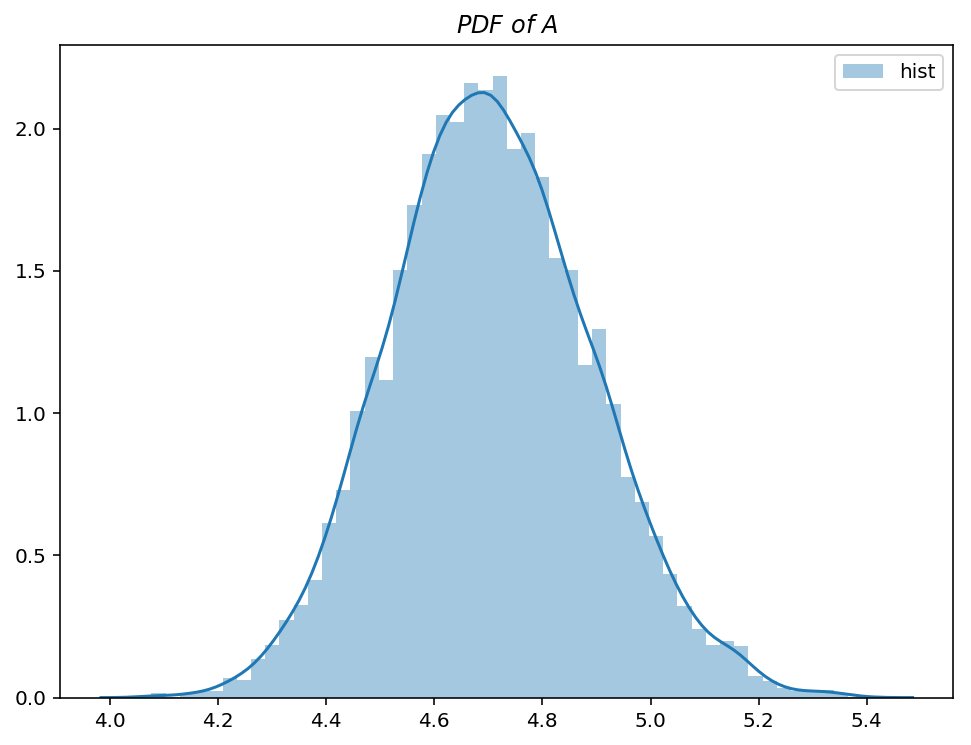

In [13]:
plt.figure(figsize=(8,6))
sns.distplot(A_array,kde=True,norm_hist=True,label='hist')
plt.title(r'$PDF \ of \ A$')
plt.legend()
plt.show()

In [14]:
print "The mean of A is found to be: ",A_array.mean()
print "The variance of A is found to be: ", A_array.var()

The mean of A is found to be:  4.70500146302
The variance of A is found to be:  0.0346760944002


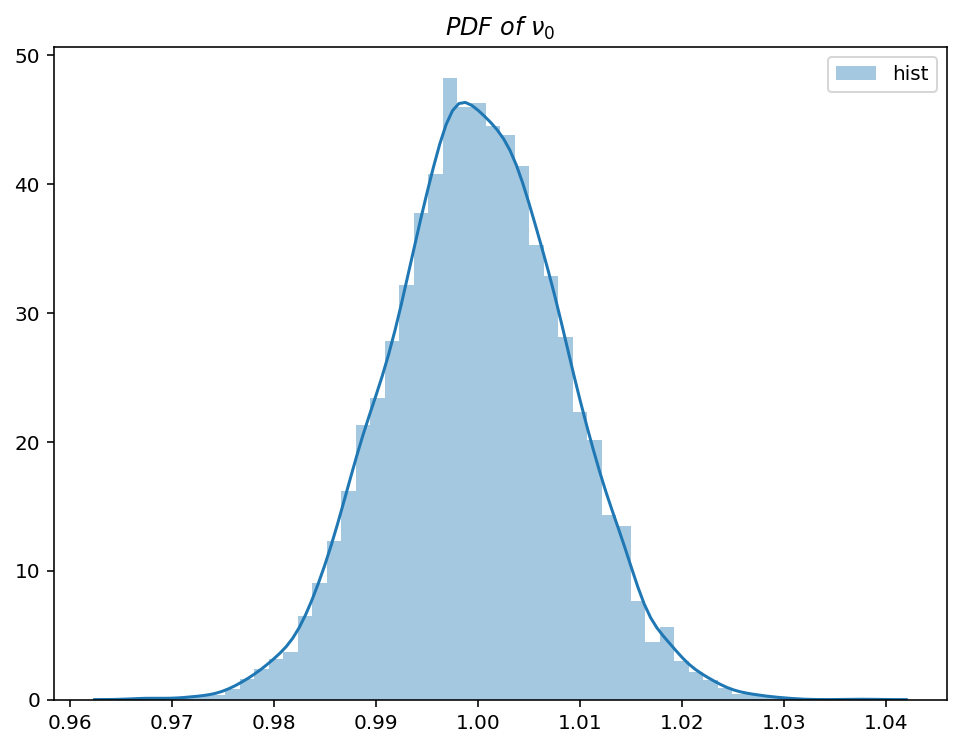

In [15]:
plt.figure(figsize=(8,6))
sns.distplot(nu0_array,kde=True,norm_hist=True,label='hist')
plt.title(r'$PDF \ of \ \nu_0$')
plt.legend()
plt.show()

In [16]:
print "The mean of nu0 is found to be: ",nu0_array.mean()
print "The variance of nu0 is found to be: ", nu0_array.var()

The mean of nu0 is found to be:  0.999967558196
The variance of nu0 is found to be:  7.34363627842e-05


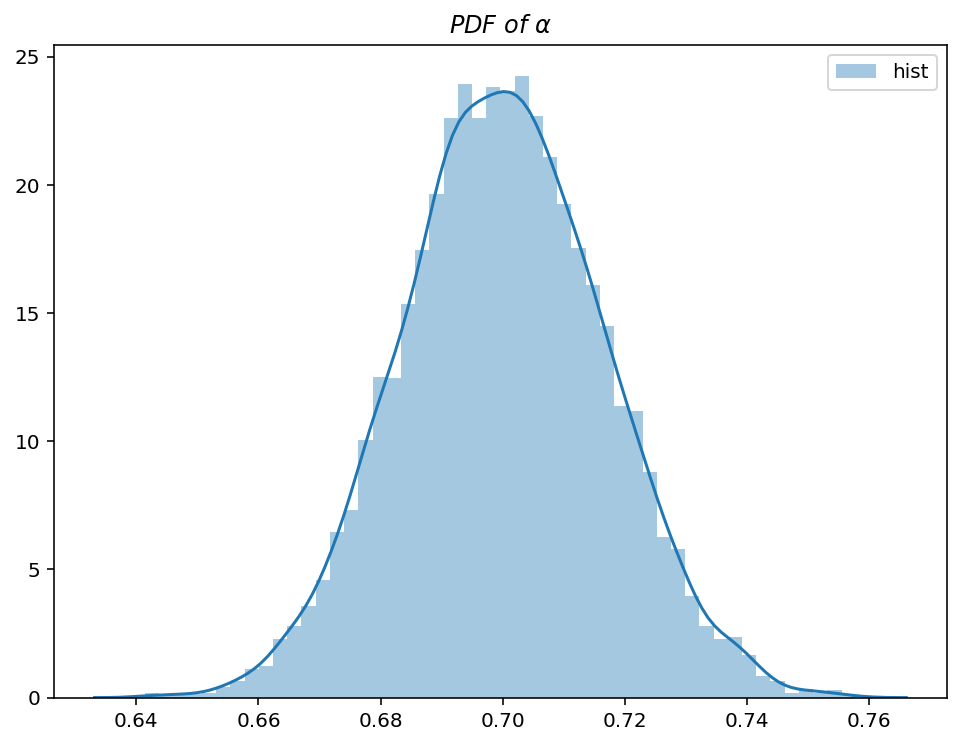

In [17]:
plt.figure(figsize=(8,6))
sns.distplot(alpha_array,kde=True,norm_hist=True,label='hist')
plt.title(r'$PDF \ of \ \alpha$')
plt.legend()
plt.show()

In [18]:
print "The mean of alpha is found to be: ",alpha_array.mean()
print "The variance of alpha is found to be: ", alpha_array.var()

The mean of alpha is found to be:  0.700124278683
The variance of alpha is found to be:  0.000272257911299


It can be seen that for a large number of simulations, the mean values of the estimators lie closely to the values found using $\textit{curve_fit}$, and their distributions are all Gaussian-like.

## Problem 4

## Fisher information matrix and CRLB matrix

The Fisher information matrix is calculated as:
\begin{align*}
J(\bar{\theta})&=
\begin{bmatrix}
-E\left[\frac{\partial^2\ln\,p(\bf{x};\Theta)}{\partial A^2}\right] & -E\left[\frac{\partial^2\ln\,p(\bf{x};\Theta)}{\partial A\partial \nu_0}\right] & -E\left[\frac{\partial^2\ln\,p(\bf{x};\Theta)}{\partial A\partial \alpha}\right]\\
-E\left[\frac{\partial^2\ln\,p(\bf{x};\Theta)}{\partial \nu_0\partial A}\right] &
-E\left[\frac{\partial^2\ln\,p(\bf{x};\Theta)}{\partial \nu_0^2}\right] & -E\left[\frac{\partial^2\ln\,p(\bf{x};\Theta)}{\partial \nu_0\partial \alpha}\right]\\
-E\left[\frac{\partial^2\ln\,p(\bf{x};\Theta)}{\partial \alpha \partial A}\right] & -E\left[\frac{\partial^2\ln\,p(\bf{x};\Theta)}{\partial \alpha \partial \nu_0}\right] & -E\left[\frac{\partial^2\ln\,p(\bf{x};\Theta)}{\partial \alpha^2}\right]
\end{bmatrix}\\
&=\begin{bmatrix}
-E\left[\frac{\partial f_1}{\partial A}\right] & -E\left[\frac{\partial f_1}{\partial \nu_0}\right] & -E\left[\frac{\partial f_1}{\partial \alpha}\right]\\
-E\left[\frac{\partial f_2}{\partial A}\right] & -E\left[\frac{\partial f_1}{\partial \nu_0}\right] & -E\left[\frac{\partial f_1}{\partial \alpha}\right]\\
-E\left[\frac{\partial f_3}{\partial A}\right] & -E\left[\frac{\partial f_1}{\partial \nu_0}\right] & -E\left[\frac{\partial f_1}{\partial \alpha}\right]
\end{bmatrix}\\
&=-\frac{1}{\sigma^2}\begin{bmatrix}
-\sum_{i=1}^Ng^2 & \sum_{i=1}^N g_1(x_i-2Ag) & \sum_{i=1}^Ng_2(x_i-2Ag)\\
\sum_{i=1}^N\alpha gh(x_i-2Ag) & \sum_{i=1}^N A\alpha \left[hg_1(x_i-2Ag)+gh_1(x_i-Ag)\right] & \sum_{i=1}^N Ah\left[g(x_i-Ag)+\alpha g_2(x_i-2Ag)\right]\\
\sum_{i=1}^Ngk(x_i-2Ag) & \sum_{i=1}^N A \left[kg_1(x_i-2Ag)+gk_1(x_i-Ag)\right] & \sum_{i=1}^N Akg_2(x_i-2Ag)
\end{bmatrix}
\end{align*}
where $\Theta = \begin{bmatrix}
A & \nu_0 & \alpha
\end{bmatrix}^T.$

The CRLB matrix is:
$$Var[\Theta] \geq \sigma^2\begin{bmatrix}
-1/\sum_{i=1}^Ng^2 \\
1/\sum_{i=1}^N A\alpha \left[hg_1(x_i-2Ag)+gh_1(x_i-Ag)\right]\\
1/\sum_{i=1}^N Akg_2(x_i-2Ag)
\end{bmatrix}$$

In [19]:
#Using the CRLB to estimate the variances
print "The variance of A is found to be:",-1/J11(SpN,freq,A_est,nu0_est,alpha_est)
print "The variance of nu0 is found to be:",-1/J22(SpN,freq,A_est,nu0_est,alpha_est)
print "The variance of alpha is found to be:",-1/J33(SpN,freq,A_est,nu0_est,alpha_est)

The variance of A is found to be: 0.00013813478605
The variance of nu0 is found to be: 5.41304000509e-05
The variance of alpha is found to be: 1.17429604883e-06


It can be seen that the variances estimated from the CRLB matrix are much smaller than that inferred from the Monte-Carlo simulations. Since the variance of any unbiased estimator is at least as high as the inverse of the Fisher information matrix. The variance inferred from Monte Carlo realisations decrease with the increase of the number of relaisations, whereas the variance inferred from Fisher information matrix is dependent on the sample size of the sataset (in this case $N=500$), and goes to zero when the sample size increases. CRLB is the lowest possible vaiance inferred from one dataset and hence is smaller than the variance estimated from the Monte Carlo simulations (which is derived from multiple realisations).

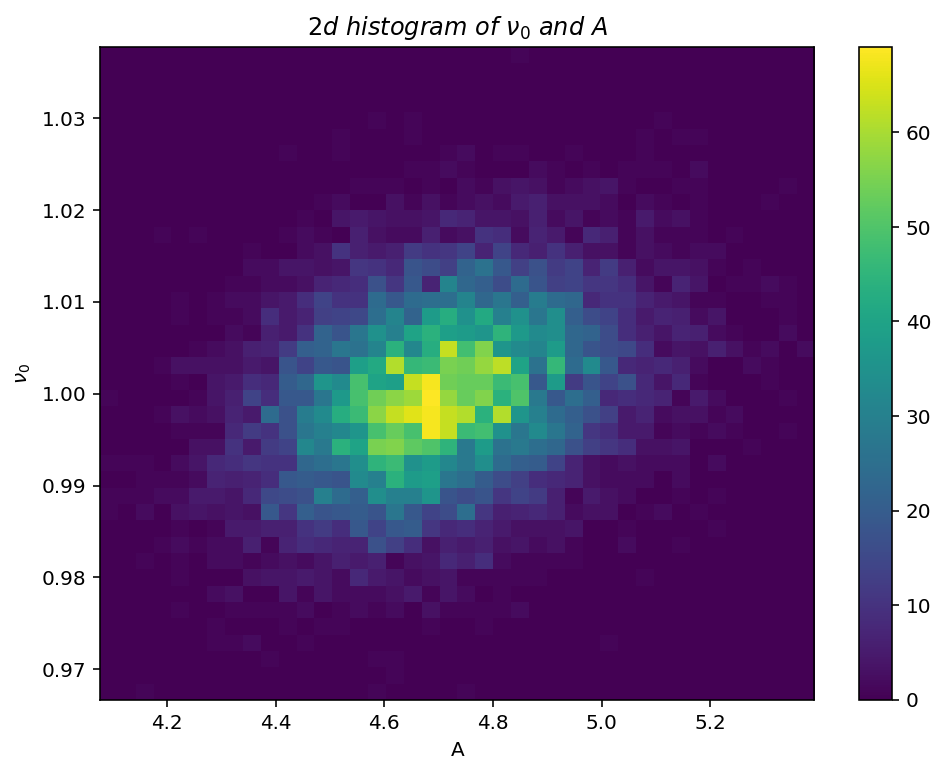

In [20]:
plt.figure(figsize=(8,6))
plt.hist2d(A_array,nu0_array,bins=40)
plt.title(r"$2d \ histogram \ of \ \nu_0 \ and \ A$")
plt.xlabel('A')
plt.ylabel(r'$\nu_0$')
plt.colorbar()
plt.show()

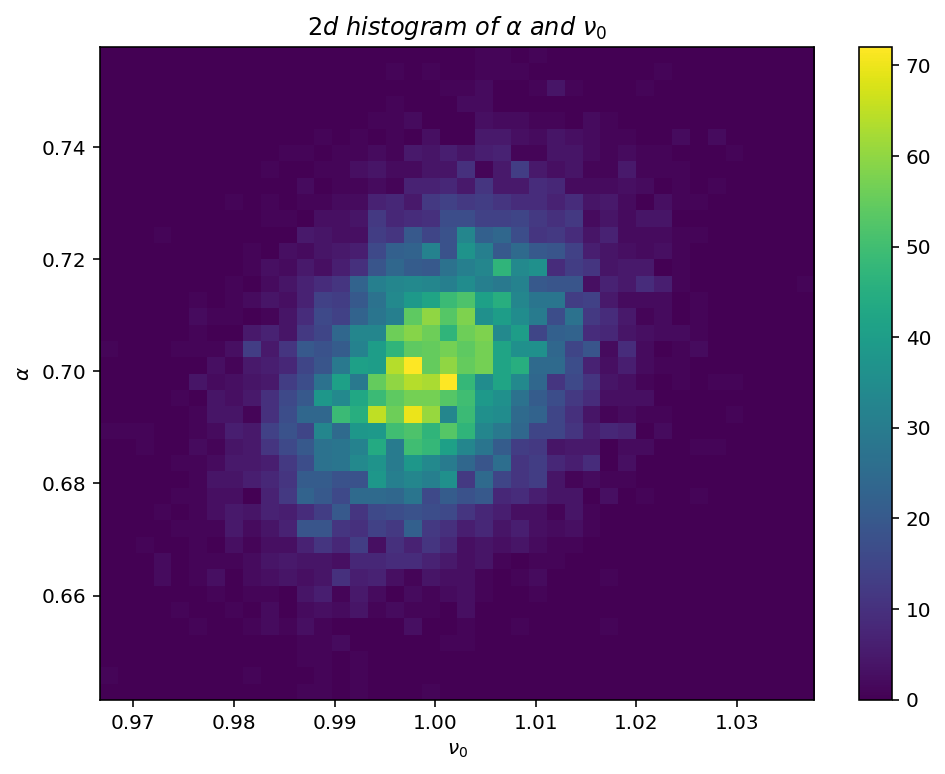

In [21]:
plt.figure(figsize=(8,6))
plt.hist2d(nu0_array,alpha_array,bins=40)
plt.title(r"$2d \ histogram \ of \ \alpha \ and \ \nu_0$")
plt.xlabel(r'$\nu_0$')
plt.ylabel(r'$\alpha$')
plt.colorbar()
plt.show()

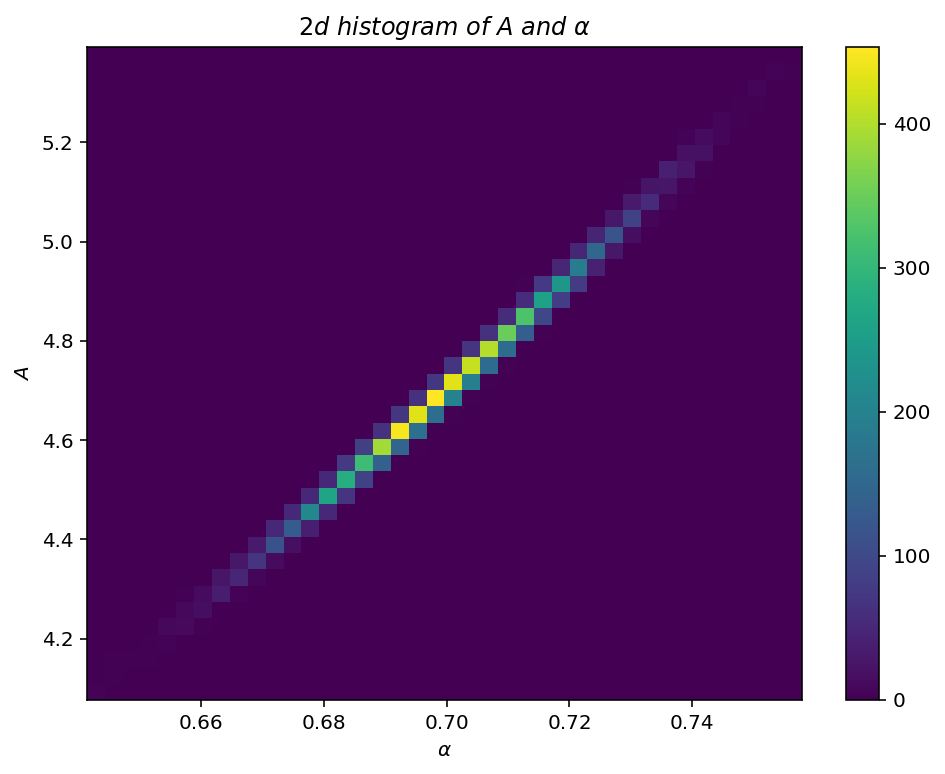

In [22]:
plt.figure(figsize=(8,6))
plt.hist2d(alpha_array,A_array,bins=40)
plt.title(r"$2d \ histogram \ of \ A \ and \ \alpha$")
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$A$')
plt.colorbar()
plt.show()

## Problem 5

## The likelihood Function

For the fact that $\frac{1}{(2\pi sigma^2)^{N/2}}=\frac{1}{(2\pi 0.05^2)^{500/2}}$ is a huge number ($\sim exp(1038)$), when calculating the PDF, this constant was omitted to avoid computation error. The PDF was later normalised as:
$$P_{unnormed}(A,\nu_0,\alpha)= \exp\left[-\frac{1}{2\sigma^2}\sum_{i=1}^N\left(x_i-A\left(\frac{\nu_i}{\nu_0}\right)^{\alpha}\left(1+\frac{\nu_i}{\nu_0}\right)^{-4\alpha}\right)^2\right]$$
Summing it along the three axes:
$$norm = \sum_{k=1}^{len(A)}\sum_{l=1}^{len(\nu_0)}\sum_{m=1}^{len(\alpha)}\exp\left[-\frac{1}{2\sigma^2}\sum_{i=1}^N\left(x_i-A_k\left(\frac{\nu_i}{\nu_{0l}}\right)^{\alpha_m}\left(1+\frac{\nu_i}{\nu_{0l}}\right)^{-4\alpha_m}\right)^2\right]dAd\nu_0d\alpha$$
where $dA$, $d\nu_0$, and $d\alpha$ are the steps of $A$, $\nu_0$ and $\alpha$, which are computed as:
\begin{align*}
dA &= (max(A)-min(A))/(len(A)-1)\\
d\nu_0 &= (max(\nu_0)-min(\nu_0))/(len(\nu_0)-1)\\
d\alpha &= (max(\alpha)-min(\alpha))/(len(\alpha)-1)
\end{align*}
Hence the normalised PDF is simply:
$$P_{normed}(A,\nu_0,\alpha)= \frac{1}{norm}\exp\left[-\frac{1}{2\sigma^2}\sum_{i=1}^N\left(x_i-A\left(\frac{\nu_i}{\nu_0}\right)^{\alpha}\left(1+\frac{\nu_i}{\nu_0}\right)^{-4\alpha}\right)^2\right]$$

In [25]:
print -500./2*np.log(2*pi*sig**2)

1038.39687017


In [30]:
def pdf(A,nu0,alpha): #the constant e^270 was there to ensure the values does not go to infinity
    N = len(freq)
    sig = .05
    prob = np.zeros((len(A),len(nu0),len(alpha)))
    for i in range(len(A)):
        for j in range(len(nu0)):
            s1 = np.zeros(len(alpha)-1)
            x1 = np.zeros(len(alpha)-1)
            area1 = np.zeros(len(alpha-1))
            for k in range(len(alpha)-1):
                power = np.sum((SpN-A[i]*(freq/nu0[j])**alpha[k]*(1.+freq/nu0[j])**(-4*alpha[k]))**2)
                prob[i][j][k] =  e**270*np.exp(-1./(2*sig**2)*power)
    # To normalise the PDF, the values must sum up to 1 along the three axes
    dA = (A.max()-A.min())/(len(A)-1)
    dnu0 = (nu0.max()-nu0.min())/(len(nu0)-1)
    dalpha = (alpha.max()-alpha.min())/(len(alpha)-1)
    norm = np.sum(prob*dA*dnu0*dalpha)
    prob = prob/norm       
    return prob       

In [31]:
sig = .05
A = np.linspace(4.,5.,300)
nu0 = np.linspace(.9,1.2,300)
alpha = np.linspace(.5,.8,300)
start = time.time()
P = pdf(A,nu0,alpha)
print "Time taken:", (time.time() - start)/60., "Minutes"



Time taken: 23.5670522014 Minutes


In [45]:
dA = (A.max()-A.min())/(len(A)-1)
dnu0 = (nu0.max()-nu0.min())/(len(nu0)-1)
dalpha = (alpha.max()-alpha.min())/(len(alpha)-1)

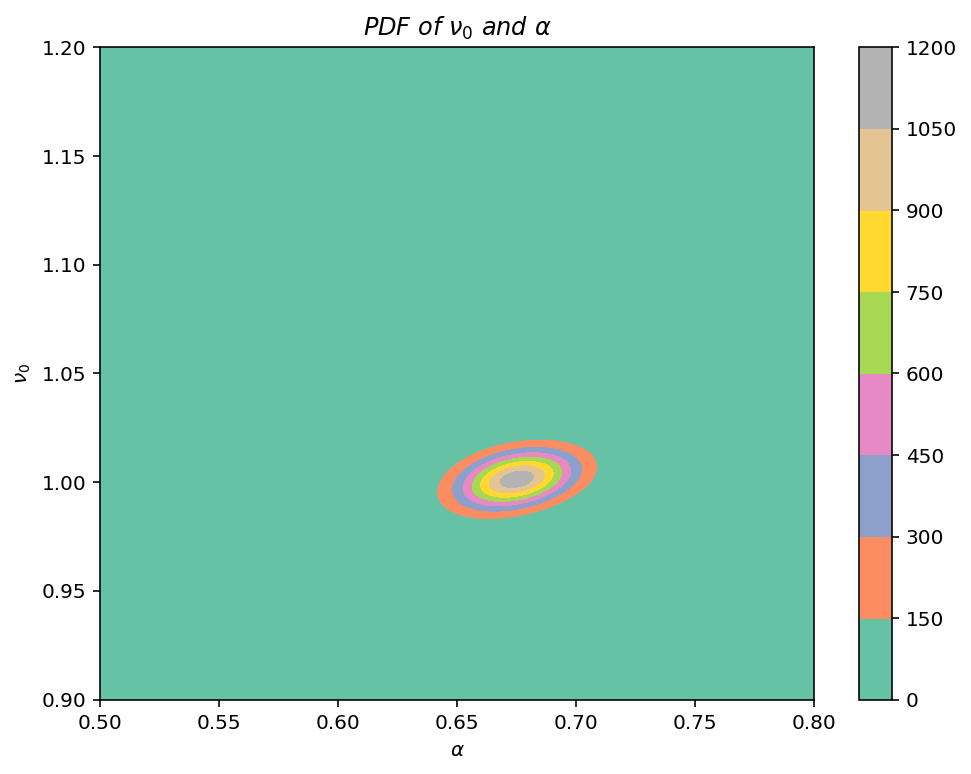

In [78]:
P_23 = np.sum(P*dA,axis=0)
plt.figure(figsize=(8,6))
plt.contourf(alpha,nu0,P_23,cmap='Set2')
plt.title(r"$PDF \ of \ \nu_0 \ and \ \alpha$")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\nu_0$")
plt.colorbar()
plt.show()

In [117]:
ind_nu0 = np.argmax(np.sum(P_23,axis=1))
ind_alpha = np.argmax(np.sum(P_23,axis=0))
print "The best estimate of nu0 is found to be: ",nu0[ind_nu0]
print "The best estimate of alpha is found to be: ",alpha[ind_alpha]

The best estimate of nu0 is found to be:  1.00133779264
The best estimate of alpha is found to be:  0.674581939799


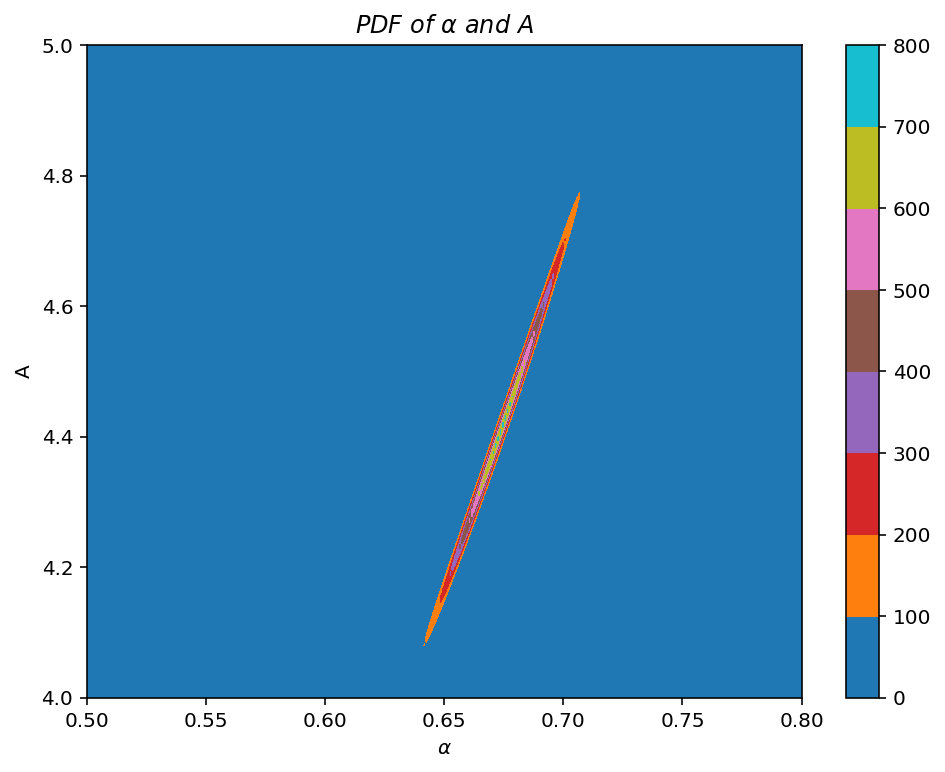

In [47]:
P_13 = np.sum(P*dnu0,axis=1)
plt.figure(figsize=(8,6))
plt.contourf(alpha,A,P_13,cmap='tab10')
plt.title(r"$PDF \ of \ \alpha \ and \ A$")
plt.xlabel(r"$\alpha$")
plt.ylabel("A")
plt.colorbar()
plt.show()

In [119]:
ind_A = np.argmax(np.sum(P_13,axis=1))
ind_alpha1 = np.argmax(np.sum(P_13,axis=0))
print "The best estimate of alpha is found to be: ",alpha[ind_alpha1]
print "The best estimate of A is found to be: ",A[ind_A]

The best estimate of alpha is found to be:  0.674581939799
The best estimate of A is found to be:  4.41137123746


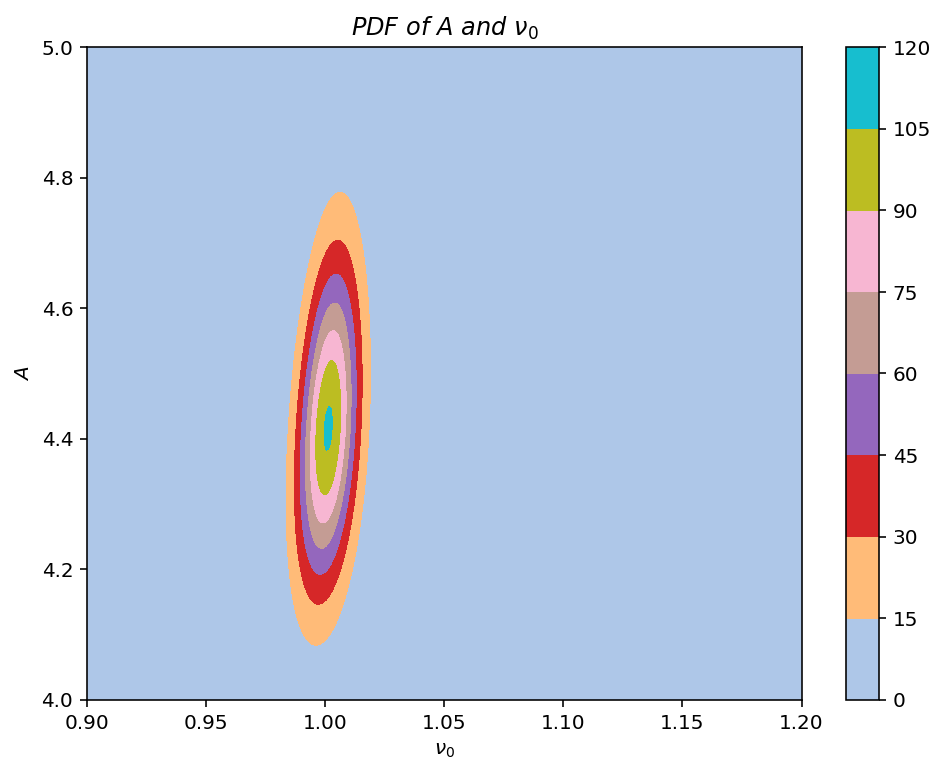

In [80]:
P_12 = np.sum(P*dalpha,axis=2)
plt.figure(figsize=(8,6))
plt.contourf(nu0,A,P_12,cmap='tab20')
plt.title(r"$PDF \ of \ A \ and \ \nu_0$")
plt.xlabel(r"$\nu_0$")
plt.ylabel(r"$A$")
plt.colorbar()
plt.show()

In [120]:
ind_A1 = np.argmax(np.sum(P_12,axis=1))
ind_nu01 = np.argmax(np.sum(P_12,axis=0))
print "The best estimate of nu0 is found to be: ",nu0[ind_nu01]
print "The best estimate of A is found to be: ",A[ind_A1]

The best estimate of nu0 is found to be:  1.00133779264
The best estimate of A is found to be:  4.41137123746


Given that the PDF is derived using the same data array in step 2, the best estimate in each coloured plot should correspnds to the best estimate found in step 2: $(A,\nu_0,\alpha) = (4.41, 1.00, 0.67)$. From the coloured plots above, the best estimate are found to be: $(A,\nu_0,\alpha) = (4.41, 1.00, 0.67)$.

## marginalised PDF of $\bf{\alpha}$

In [83]:
P_3 = np.sum(P_23*dnu0,axis=0)
#to verify that the marginalised pdf indeed sum up to unity:
print "The sum along axis alpha is: ", np.sum(P_3*dalpha)

The sum along axis alpha is:  1.0


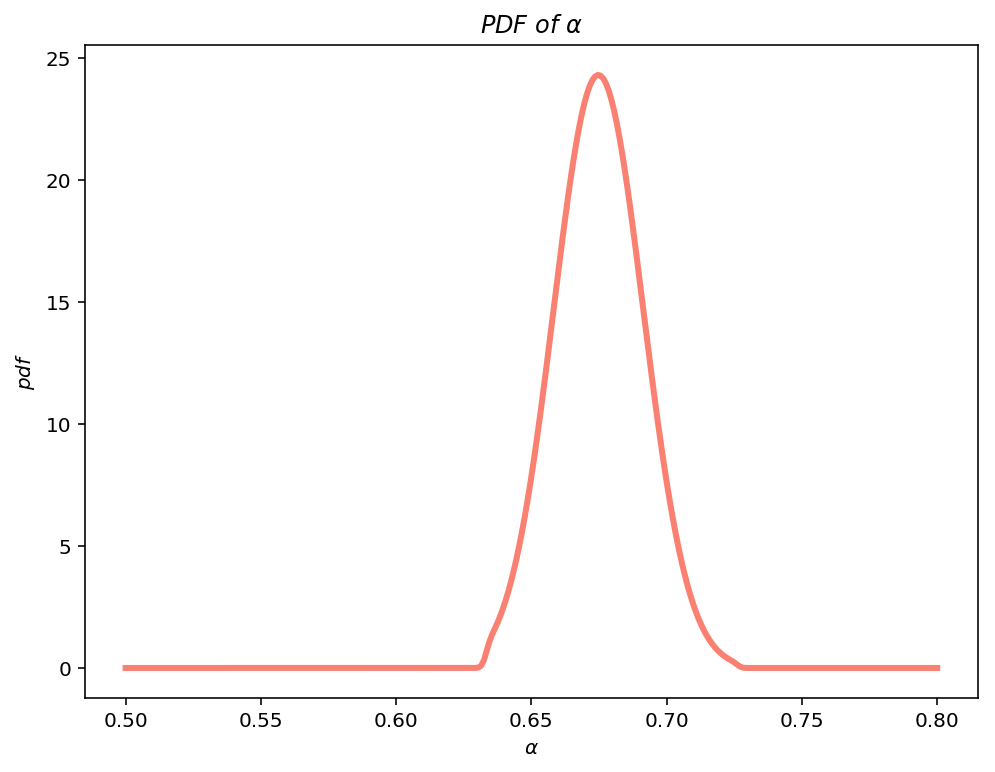

In [125]:
plt.figure(figsize=(8,6))
plt.plot(alpha,P_3,lw=3,color='salmon')
plt.title(r"$PDF \ of \ \alpha$")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$pdf$")
plt.show()

In [128]:
ind3 = np.argmax(P_3)
print "The best estimate of alpha is found to be: ",alpha[ind3]

The best estimate of alpha is found to be:  0.674581939799


## marginalised PDF of $\bf{\nu_0}$

In [85]:
P_2 = np.sum(P_23*dalpha,axis=1)
#to verify that the marginalised pdf indeed sum up to unity:
print "The sum along axis nu0 is: ", np.sum(P_2*dnu0)

The sum along axis nu0 is:  1.0


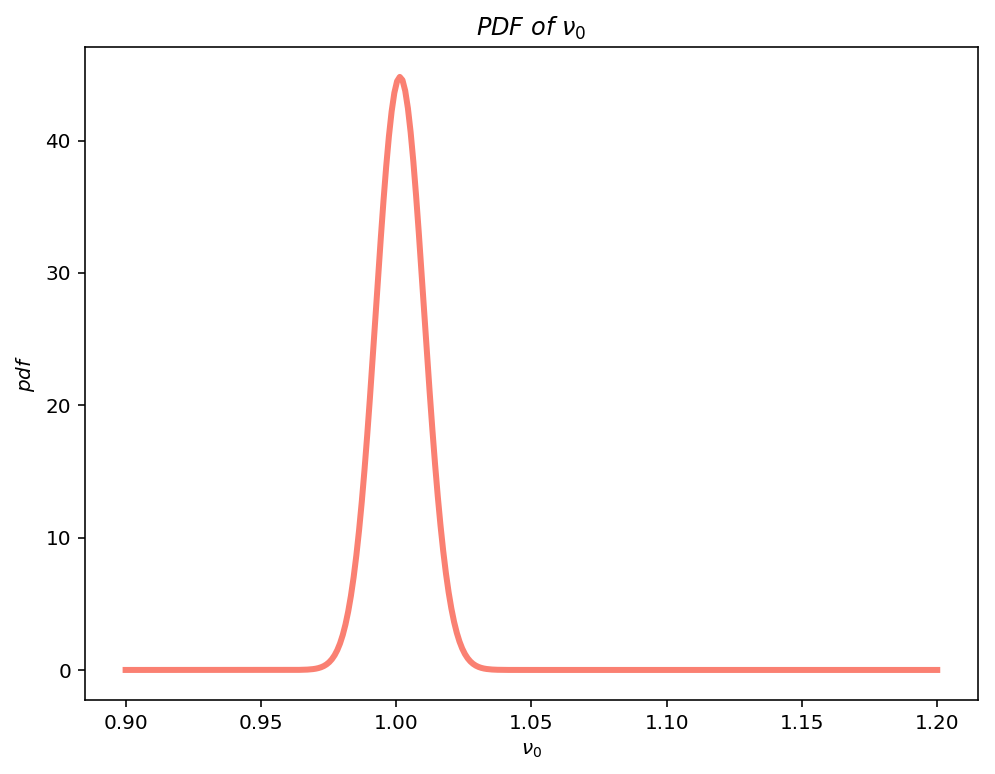

In [126]:
plt.figure(figsize=(8,6))
plt.plot(nu0,P_2,lw=3,color='salmon')
plt.title(r"$PDF \ of \ \nu_0$")
plt.xlabel(r"$\nu_0$")
plt.ylabel(r"$pdf$")
plt.show()

In [130]:
ind2 = np.argmax(P_2)
print "The best estimate of nu0 is found to be: ",nu0[ind2]

The best estimate of nu0 is found to be:  1.00133779264


## marginalised PDF of $\bf{A}$

In [104]:
P_1 = np.sum(P_13*dalpha,axis=1)
#to verify that the marginalised pdf indeed sum up to unity:
print "The sum along axis A is: ", np.sum(P_1*dA)

The sum along axis A is:  1.0


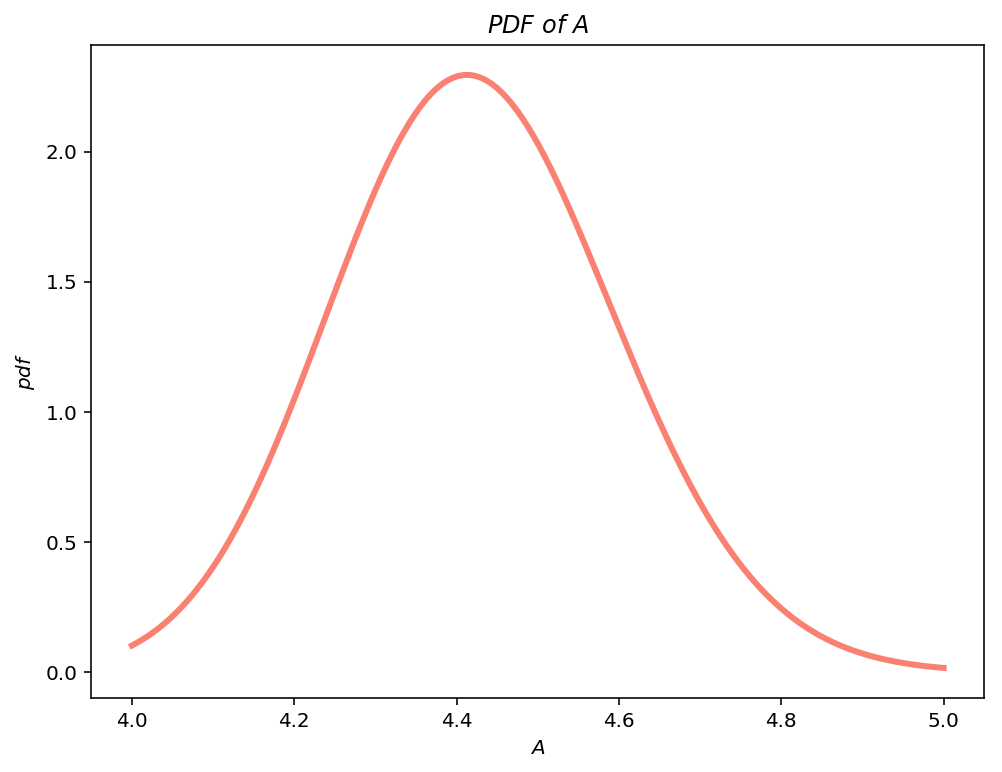

In [127]:
plt.figure(figsize=(8,6))
plt.plot(A,P_1,lw=3,color='salmon')
plt.title(r"$PDF \ of \ A$")
plt.xlabel(r"$A$")
plt.ylabel(r"$pdf$")
plt.show()

In [131]:
ind1 = np.argmax(P_1)
print "The best estimate of A is found to be: ",A[ind1]

The best estimate of A is found to be:  4.41137123746


It can be seen that the PDFs of the three parameters are indeed Gausian-like, as exprected.